In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Load your dataset
input_file = "/content/Supplementary data 3.xlsx"  # Replace with your actual file path
data = pd.read_excel(input_file)

# Separate features and target variable (TYPE)
X = data.drop(columns=["TYPE"])  # Drop the 'TYPE' column to get the features
y = data["TYPE"]  # 'TYPE' is the target variable

# Scale the features (important for KDE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KDE to the scaled data
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)  # You can adjust the bandwidth
kde.fit(X_scaled)

# Generate synthetic samples using KDE sampling
num_samples_to_generate = 2000  # Define the number of synthetic samples you want to generate

# Sample new data points from the KDE distribution
log_density_samples = kde.sample(num_samples_to_generate)

# Revert scaling transformation
synthetic_samples = scaler.inverse_transform(log_density_samples)

# Ensure categorical columns (if any) stay within binary [0, 1] (only for binary categorical columns)
# Apply np.clip to ensure no negative values in synthetic data
synthetic_samples = np.clip(synthetic_samples, 0, None)

# Ensure the 'Menopause' feature is only 0 or 1 (binary) for all synthetic samples
# Assuming 'Menopause' is at index 17 based on the provided column list
menopause_column_index = X.columns.get_loc('Menopause')

# Round 'Menopause' column to ensure it contains only 0 or 1
synthetic_samples[:, menopause_column_index] = np.round(synthetic_samples[:, menopause_column_index])

# If any values in 'Menopause' are 2.0 (after rounding), set them to 0 or 1 based on a rule
synthetic_samples[:, menopause_column_index] = np.where(
    synthetic_samples[:, menopause_column_index] == 2.0,
    np.random.choice([0, 1], size=synthetic_samples.shape[0]),  # Randomly assign 0 or 1
    synthetic_samples[:, menopause_column_index]
)

# Convert the synthetic samples to a DataFrame
augmented_X = pd.DataFrame(synthetic_samples, columns=X.columns)

# Since you want a distribution for the 'TYPE' column, we need to sample from the original `y` distribution
# Sample target labels for the synthetic samples based on the original distribution
augmented_y = np.random.choice(y, size=num_samples_to_generate, replace=True)

# Combine augmented data with the target variable 'TYPE'
augmented_data = pd.DataFrame(augmented_X, columns=X.columns)
augmented_data['TYPE'] = augmented_y

# Shuffle the final augmented data
augmented_data = shuffle(augmented_data, random_state=42)

# Save the augmented dataset to CSV
output_file = "augmented_data.csv"
augmented_data.to_csv(output_file, index=False)

print(f"Augmented dataset saved to {output_file}")
print(f"Original dataset size: {len(data)} samples")
print(f"Resampled dataset size: {len(augmented_data)} samples")


Augmented dataset saved to augmented_data.csv
Original dataset size: 235 samples
Resampled dataset size: 2000 samples


In [3]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8

In [4]:
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)

In [5]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=data,
    synthetic_data=augmented_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 49/49 [00:00<00:00, 1484.61it/s]|
Data Validity Score: 94.29%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 210.60it/s]|
Data Structure Score: 88.46%

Overall Score (Average): 91.37%



In [6]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    data,
    augmented_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 49/49 [00:00<00:00, 535.59it/s]|
Column Shapes Score: 89.55%

(2/2) Evaluating Column Pair Trends: |██████████| 1176/1176 [00:06<00:00, 184.50it/s]|
Column Pair Trends Score: 97.11%

Overall Score (Average): 93.33%



In [7]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,TYPE,TVComplement,0.995777
1,MPV,KSComplement,0.934947
2,BASO#,KSComplement,0.886181
3,PHOS,KSComplement,0.947043
4,GLU.,KSComplement,0.884128
5,K,KSComplement,0.935170
6,AST,KSComplement,0.890277
7,BASO%,KSComplement,0.903904
8,Mg,KSComplement,0.922543
9,Menopause,TVComplement,0.992979


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df2 = pd.read_csv('/content/augmented_data.csv')
# Select features (excluding the 'SUBJECT_ID' and the target 'TYPE')
X = df2.drop(columns=['TYPE'])
y = df2['TYPE']

# Standardize the features for better performance in logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Let's inspect the shapes to make sure everything looks correct
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 48), (400, 48), (1600,), (400,))

In [9]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model using the training data
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [10]:
y_pred = log_reg.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6275


In [12]:
import numpy as np
# Get the feature coefficients (weights)
coefficients = log_reg.coef_[0]

# Function to calculate the sigmoid of a value
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function to calculate the summary for each data point
def generate_summary(X_test, coefficients, feature_names, model):
    results = []

    # Compute the linear model (dot product of X and coefficients) and the probabilities
    linear_model = np.dot(X_test, coefficients) + model.intercept_[0]
    probabilities = sigmoid(linear_model)

    # Loop through each data point in the test set
    for idx, (sample, prob) in enumerate(zip(X_test, probabilities)):
        # Calculate contributions for all features for this sample
        contributions = sample * coefficients
        absolute_contributions = np.abs(contributions)

        # Find the most important feature (the one with the highest absolute contribution)
        most_important_feature_idx = np.argmax(absolute_contributions)
        most_important_feature = feature_names[most_important_feature_idx]
        contribution_value = contributions[most_important_feature_idx]

        # Add the summary for this data point
        results.append({
            'Data Point': idx + 1,
            'Most Important Feature': most_important_feature,
            'Contribution Value': contribution_value,
            'Predicted Probability (P(y=1))': prob
        })

    # Convert results to a DataFrame
    summary_df = pd.DataFrame(results)

    return summary_df

# Generate the summary for all test samples
summary_table = generate_summary(X_test, coefficients, X.columns, log_reg)

# Display the first few rows of the summary
summary_table.head(20)  # Displaying the top 20 rows for brevity

,Data Point,Most Important Feature,Contribution Value,Predicted Probability (P(y=1))
0,1,Na,0.213345,0.344262
1,2,TP,0.320128,0.385321
2,3,MPV,0.122995,0.356025
3,4,EO%,0.245209,0.306066
4,5,PCT,0.462505,0.412691
5,6,ALB,-0.223429,0.338357
6,7,RBC,0.266778,0.343077
7,8,Na,-0.142040,0.450272
8,9,CO2CP,-0.297922,0.332420
9,10,Na,-0.172225,0.340497


In [13]:
summary_table['Most Important Feature'].value_counts()

,count
Most Important Feature,
TP,66
ALT,49
Na,46
ALB,45
CO2CP,41
HE4,24
BASO%,19
CL,14
IBIL,13


In [14]:
# Step 1: Extract the list of important features from the summary table
important_features = summary_table['Most Important Feature'].unique()

# Step 2: Filter the dataset to only include important features
features = [feature for feature in important_features if feature in df2.columns]

# Step 3: Add the important features to X
X = df2[features].values

print(f"Updated X now includes only important features: {features}")


# Step 4: Include the target label
selected_features_df = df2[features + ['TYPE']]  # Assuming 'TYPE' is the target column

# Step 5: Save the selected features to a CSV file
selected_features_df.to_csv('sel_features.csv', index=False)

print("Selected features and labels saved to 'sel_features.csv'.")


Updated X now includes only important features: ['Na', 'TP', 'MPV', 'EO%', 'PCT', 'ALB', 'RBC', 'CO2CP', 'HE4', 'PDW', 'BASO%', 'ALP', 'GGT', 'CL', 'ALT', 'LYM%', 'AFP', 'CA19-9', 'Menopause', 'MONO#', 'LYM#', 'BUN', 'IBIL', 'PHOS', 'Age', 'TBIL', 'AG', 'CEA']
Selected features and labels saved to 'sel_features.csv'.


In [15]:
# Restart the kernel before running the code below
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201

In [16]:
# Load the synthetic data from CSV and prepare it for the SAINT model
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load the data
file_path = '/content/sel_features.csv'
data = pd.read_csv(file_path)

# Split features and target
X = data.values
y = data['TYPE'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define the SAINT model
class SimpleSAINT(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_classes=3,num_self_attn_layers=2,use_intersample_attn=True):
        super(SimpleSAINT, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        attention_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attention_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        x = torch.mean(x, dim=1)
        x = self.classifier(x)
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SimpleSAINT(input_dim=input_dim, hidden_dim=64, num_heads=4, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    _, predicted_train = torch.max(outputs.data, 1)
    train_acc = accuracy_score(y_train.numpy(), predicted_train.numpy())

    # Calculate test accuracy
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted_test = torch.max(test_outputs.data, 1)
        test_acc = accuracy_score(y_test.numpy(), predicted_test.numpy())

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_outputs = model(X_test)
    _, predicted = torch.max(final_outputs.data, 1)
    final_accuracy = accuracy_score(y_test.numpy(), predicted.numpy())

print(f"Final Test Accuracy: {final_accuracy:.4f}")

# Classification Metrics (From Code 1)
print("\nClassification Report:")
print(classification_report(y_test.numpy(), predicted.numpy()))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test.numpy(), predicted.numpy())
print("\nConfusion Matrix:")
print(conf_matrix)

# Compute ROC-AUC Score (for binary classification)
if len(set(y_test.numpy())) == 2:  # Ensure binary classification
    y_probs = F.softmax(final_outputs, dim=1)[:, 1].numpy()  # Get probabilities for class 1
    roc_auc = roc_auc_score(y_test.numpy(), y_probs)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

ImportError: cannot import name 'code_framelocals_names' from 'torch._C._dynamo.eval_frame' (unknown location)

PyTorch version: 2.7.1+cu126
Epoch 1/40, Loss: 1.1764, Train Acc: 0.3394, Test Acc: 0.4725
Epoch 2/40, Loss: 1.0199, Train Acc: 0.4631, Test Acc: 0.5600
Epoch 3/40, Loss: 0.9077, Train Acc: 0.5431, Test Acc: 0.5975
Epoch 4/40, Loss: 0.8266, Train Acc: 0.5887, Test Acc: 0.6250
Epoch 5/40, Loss: 0.7745, Train Acc: 0.6088, Test Acc: 0.6350
Epoch 6/40, Loss: 0.7368, Train Acc: 0.6150, Test Acc: 0.6375
Epoch 7/40, Loss: 0.7129, Train Acc: 0.6156, Test Acc: 0.6250
Epoch 8/40, Loss: 0.6931, Train Acc: 0.6194, Test Acc: 0.6200
Epoch 9/40, Loss: 0.6820, Train Acc: 0.6200, Test Acc: 0.6225
Epoch 10/40, Loss: 0.6733, Train Acc: 0.6162, Test Acc: 0.6025
Epoch 11/40, Loss: 0.6687, Train Acc: 0.6169, Test Acc: 0.5900
Epoch 12/40, Loss: 0.6636, Train Acc: 0.6231, Test Acc: 0.5975
Epoch 13/40, Loss: 0.6600, Train Acc: 0.6288, Test Acc: 0.6225
Epoch 14/40, Loss: 0.6561, Train Acc: 0.6281, Test Acc: 0.6250
Epoch 15/40, Loss: 0.6553, Train Acc: 0.6331, Test Acc: 0.6225
Epoch 16/40, Loss: 0.6536, Train Ac

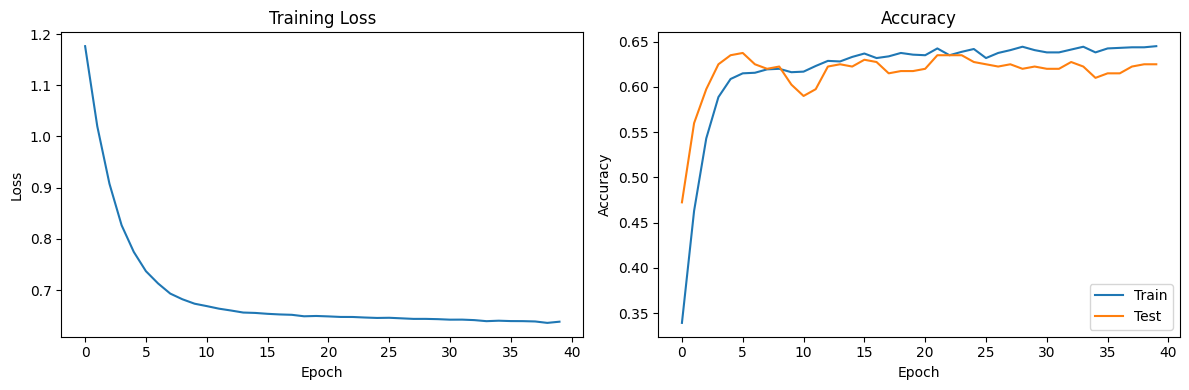

In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load the data
file_path = '/content/sel_features.csv'
data = pd.read_csv(file_path)

# Split features and target
X = data.drop('TYPE', axis=1).values  # Modified to explicitly drop target column
y = data['TYPE'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define the enhanced SAINT model
class EnhancedSAINT(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_classes=3,
                 num_self_attn_layers=2, use_intersample_attn=True):
        super(EnhancedSAINT, self).__init__()
        self.hidden_dim = hidden_dim
        self.use_intersample_attn = use_intersample_attn

        # Feature embedding
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Multiple self-attention layers
        self.self_attentions = nn.ModuleList([
            nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
            for _ in range(num_self_attn_layers)
        ])
        self.self_attn_norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(num_self_attn_layers)
        ])

        # Intersample attention (optional)
        if use_intersample_attn:
            self.intersample_attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
            self.intersample_norm = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.ffn_norm = nn.LayerNorm(hidden_dim)

        # Classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Embed features
        x = self.embedding(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # Add sequence dimension if missing

        # Self-attention layers
        for attn, norm in zip(self.self_attentions, self.self_attn_norms):
            attn_out, _ = attn(x, x, x)
            x = norm(x + attn_out)

        # Intersample attention
        if self.use_intersample_attn:
            batch_size, num_features, _ = x.shape
            x_reshaped = x.reshape(-1, self.hidden_dim).unsqueeze(0)
            intersample_out, _ = self.intersample_attention(x_reshaped, x_reshaped, x_reshaped)
            x = x + intersample_out.squeeze(0).view(batch_size, num_features, self.hidden_dim)
            x = self.intersample_norm(x)

        # Feed-forward network
        ffn_out = self.ffn(x)
        x = self.ffn_norm(x + ffn_out)

        # Pool features and classify
        x = torch.mean(x, dim=1)
        return self.classifier(x)

# Initialize model
input_dim = X_train.shape[1]
model = EnhancedSAINT(
    input_dim=input_dim,
    hidden_dim=64,
    num_heads=4,
    num_classes=3,
    num_self_attn_layers=2,
    use_intersample_attn=True
)

# Verify PyTorch version
print(f"PyTorch version: {torch.__version__}")

# If you get the original error, try reinstalling PyTorch:
# !pip install torch --upgrade --force-reinstall

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    _, predicted_train = torch.max(outputs.data, 1)
    train_acc = accuracy_score(y_train.numpy(), predicted_train.numpy())

    # Calculate test accuracy
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted_test = torch.max(test_outputs.data, 1)
        test_acc = accuracy_score(y_test.numpy(), predicted_test.numpy())

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_outputs = model(X_test)
    _, predicted = torch.max(final_outputs.data, 1)
    final_accuracy = accuracy_score(y_test.numpy(), predicted.numpy())

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

# Classification Metrics
print("\nClassification Report:")
print(classification_report(y_test.numpy(), predicted.numpy()))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test.numpy(), predicted.numpy()))

# ROC-AUC for binary classification
if len(set(y_test.numpy())) == 2:
    y_probs = F.softmax(final_outputs, dim=1)[:, 1].numpy()
    roc_auc = roc_auc_score(y_test.numpy(), y_probs)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
!pip install torch --upgrade --force-reinstall

  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x8

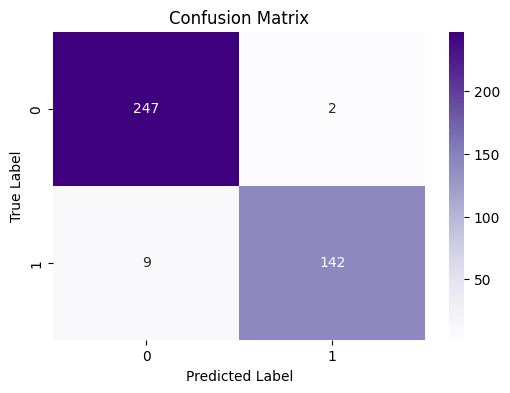

In [ ]:
import seaborn as sns

# Plot Confusion Matrix as a Table
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=set(y_test.numpy()), yticklabels=set(y_test.numpy()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

# Load your dataset
data = pd.read_csv("augmented_data.csv")

# Separate features and target variable (TYPE)
X = data[important_features_list]
y = data["TYPE"]

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build a deep learning model (fully connected neural network)
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', AUC()])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.2f}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5712 - auc: 0.5304 - loss: 0.6794 - val_accuracy: 0.6500 - val_auc: 0.4314 - val_loss: 0.6740
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6079 - auc: 0.5507 - loss: 0.6704 - val_accuracy: 0.6400 - val_auc: 0.4248 - val_loss: 0.6751
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6154 - auc: 0.6257 - loss: 0.6489 - val_accuracy: 0.6400 - val_auc: 0.4209 - val_loss: 0.6774
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - auc: 0.6710 - loss: 0.6528 - val_accuracy: 0.6450 - val_auc: 0.4229 - val_loss: 0.6802
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6269 - auc: 0.6781 - loss: 0.6324 - val_accuracy: 0.6350 - val_auc: 0.4254 - val_loss: 0.6800
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6218 - auc: 0.6907 - loss: 0.6344 - val_accuracy: 0.6450 - val_auc: 0.4420 - val_loss: 0.6833
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 

PCA + FCNN

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Select features (excluding the 'TYPE')
X = augmented_data.drop(columns=['TYPE'])
y = augmented_data['TYPE']

# Standardize the features for better performance in PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize PCA to reduce dimensions while keeping 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Get the components (loadings) of PCA
pca_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

# Function to calculate contributions and generate summary for PCA-transformed data
def generate_pca_summary(X_test, components, feature_names):
    results = []

    # Compute the contributions for each data point in the test set
    for idx, sample in enumerate(X_test):
        contributions = np.dot(sample, components)  # Project the sample onto the PCA components
        absolute_contributions = np.abs(contributions)

        # Find the most important feature (the one with the highest absolute contribution)
        most_important_feature_idx = np.argmax(absolute_contributions)
        most_important_feature = feature_names[most_important_feature_idx]
        contribution_value = contributions[most_important_feature_idx]

        # Add the summary for this data point
        results.append({
            'Data Point': idx + 1,
            'Most Important Feature': most_important_feature,
            'Contribution Value': contribution_value
        })

    # Convert results to a DataFrame
    summary_df = pd.DataFrame(results)

    return summary_df

# Generate the summary for all test samples
summary_table = generate_pca_summary(X_test_pca, pca_components, X.columns)

# Display the first few rows of the summary
print(summary_table.head(20))  # Displaying the top 20 rows for brevity

# Analyze the most important features
important_features_list = summary_table['Most Important Feature'].value_counts().index.tolist()

# Print the important features list
print("Important Features List:", important_features_list)


    Data Point Most Important Feature  Contribution Value
0            1                    ALB            2.276559
1            2                 CA19-9            6.892047
2            3                     Mg           -2.996039
3            4                    AST            3.339461
4            5                    Age           -1.258343
5            6                    ALB            1.850789
6            7                   GLU.            3.852753
7            8                    HE4            4.747021
8            9                     Mg            2.301953
9           10                    AST            3.640101
10          11                    HE4            8.239094
11          12                    ALB            1.969923
12          13                    ALP            2.001772
13          14                    PCT            1.578138
14          15                  CO2CP            2.313648
15          16                     Ca           -5.057156
16          17

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

data = pd.read_csv("augmented_data.csv")


# Separate features and target variable (TYPE)
X = data[important_features_list]
y = data["TYPE"]

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build a deep learning model (fully connected neural network)
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', AUC()])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.2f}")



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5187 - auc_1: 0.4939 - loss: 0.7004 - val_accuracy: 0.6300 - val_auc_1: 0.4793 - val_loss: 0.6693
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6537 - auc_1: 0.5836 - loss: 0.6336 - val_accuracy: 0.6350 - val_auc_1: 0.4896 - val_loss: 0.6650
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6379 - auc_1: 0.6954 - loss: 0.6286 - val_accuracy: 0.6300 - val_auc_1: 0.4898 - val_loss: 0.6643
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6564 - auc_1: 0.7204 - loss: 0.6175 - val_accuracy: 0.6350 - val_auc_1: 0.5012 - val_loss: 0.6641
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6615 - auc_1: 0.7596 - loss: 0.5933 - val_accuracy: 0.6250 - val_auc_1: 0.4980 - val_loss: 0.6662
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7074 - auc_1: 0.7737 - loss: 0.5763 - val_accuracy: 0.6150 - val_auc_1: 0.5046 - val_loss: 0.6668
Epoch 7/50
25/25 ━━━━━━━━━━

LR + SAINT



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features (excluding the 'SUBJECT_ID' and the target 'TYPE')
X = augmented_data.drop(columns=['TYPE'])
y = augmented_data['TYPE']

# Standardize the features for better performance in logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Let's inspect the shapes to make sure everything looks correct
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 48), (200, 48), (800,), (200,))

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model using the training data
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.54


In [ ]:
import numpy as np
# Get the feature coefficients (weights)
coefficients = log_reg.coef_[0]

# Function to calculate the sigmoid of a value
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function to calculate the summary for each data point
def generate_summary(X_test, coefficients, feature_names, model):
    results = []

    # Compute the linear model (dot product of X and coefficients) and the probabilities
    linear_model = np.dot(X_test, coefficients) + model.intercept_[0]
    probabilities = sigmoid(linear_model)

    # Loop through each data point in the test set
    for idx, (sample, prob) in enumerate(zip(X_test, probabilities)):
        # Calculate contributions for all features for this sample
        contributions = sample * coefficients
        absolute_contributions = np.abs(contributions)

        # Find the most important feature (the one with the highest absolute contribution)
        most_important_feature_idx = np.argmax(absolute_contributions)
        most_important_feature = feature_names[most_important_feature_idx]
        contribution_value = contributions[most_important_feature_idx]

        # Add the summary for this data point
        results.append({
            'Data Point': idx + 1,
            'Most Important Feature': most_important_feature,
            'Contribution Value': contribution_value,
            'Predicted Probability (P(y=1))': prob
        })

    # Convert results to a DataFrame
    summary_df = pd.DataFrame(results)

    return summary_df

# Generate the summary for all test samples
summary_table = generate_summary(X_test, coefficients, X.columns, log_reg)

# Display the first few rows of the summary
summary_table.head(20)  # Displaying the top 20 rows for brevity

summary_table['Most Important Feature'].value_counts()

,count
Most Important Feature,
MONO#,42
LYM#,26
CREA,22
Ca,22
TBIL,21
GLO,17
PCT,11
MONO%,10
LYM%,10


In [ ]:
# Assuming 'Most Important Feature' is the column in your summary table
important_features_list = summary_table['Most Important Feature'].value_counts().index.tolist()

# Print the important features list
print(important_features_list)

['MONO#', 'LYM#', 'CREA', 'Ca', 'TBIL', 'GLO', 'PCT', 'MONO%', 'LYM%', 'MCV', 'CA19-9', 'DBIL', 'Age', 'BASO#', 'CO2CP', 'NEU']


Epoch 10/50, Loss: 0.6857, Train Acc: 0.6300, Test Acc: 0.5200
Epoch 20/50, Loss: 0.6355, Train Acc: 0.6538, Test Acc: 0.5500
Epoch 30/50, Loss: 0.6240, Train Acc: 0.6587, Test Acc: 0.5500
Epoch 40/50, Loss: 0.6121, Train Acc: 0.6687, Test Acc: 0.5400
Epoch 50/50, Loss: 0.5966, Train Acc: 0.6963, Test Acc: 0.5150
Final Test Accuracy: 0.5150


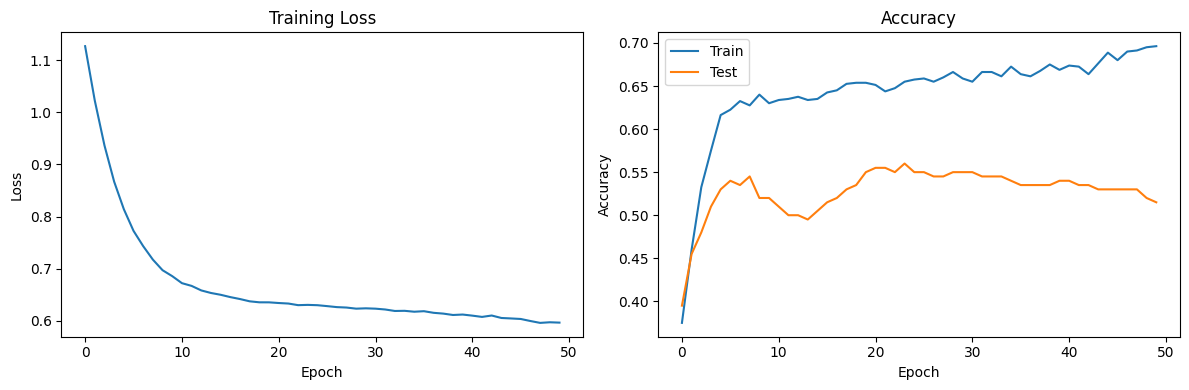

In [ ]:
# Load the synthetic data from CSV and prepare it for the SAINT model
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the data
file_path = 'augmented_data.csv'
data = pd.read_csv(file_path)

# Split features and target

X = data[important_features_list].values
y = data['TYPE'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define the SAINT model
class SimpleSAINT(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_classes=3):
        super(SimpleSAINT, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        attention_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attention_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        x = torch.mean(x, dim=1)
        x = self.classifier(x)
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SimpleSAINT(input_dim=input_dim, hidden_dim=64, num_heads=4, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    _, predicted_train = torch.max(outputs.data, 1)
    train_acc = accuracy_score(y_train.numpy(), predicted_train.numpy())

    # Calculate test accuracy
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted_test = torch.max(test_outputs.data, 1)
        test_acc = accuracy_score(y_test.numpy(), predicted_test.numpy())

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_outputs = model(X_test)
    _, predicted = torch.max(final_outputs.data, 1)
    final_accuracy = accuracy_score(y_test.numpy(), predicted.numpy())

print(f"Final Test Accuracy: {final_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.4 MB/s eta 0:00:00
Selected Features: ['MPV', 'AST', 'Mg', 'Menopause', 'CL', 'CEA', 'CA19-9', 'ALB', 'Age', 'PDW', 'HE4', 'LYM#', 'CA125', 'LYM%', 'NEU', 'PCT', 'CO2CP']
Tentative Features: ['MCH', 'ALP']

Feature Scores:
      Feature  Importance
0         MPV           1
27        HE4           1
13        ALB           1
12     CA19-9           1
28       LYM#           1
10        CEA           1
9          CL           1
22        PDW           1
8   Menopause           1
29      CA125           1
5         AST           1
31       LYM%           1
36        NEU           1
41        PCT           1
42      CO2CP           1
7          Mg           1
20        Age           1
47        ALP           2
16        MCH           2
35        PLT           3
6       BASO%           3
38         TP           4
18        ALT           6
23       CREA           6
24        AFP           8
26         Na           8
14       IBIL   

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5654 - loss: 15.7035 - val_accuracy: 0.7632 - val_loss: 2.1970
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7267 - loss: 3.3937 - val_accuracy: 0.6579 - val_loss: 2.6857
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6911 - loss: 3.4757 - val_accuracy: 0.8421 - val_loss: 1.8652
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7467 - loss: 3.6061 - val_accuracy: 0.8684 - val_loss: 1.9113
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7403 - loss: 4.3038 - val_accuracy: 0.8684 - val_loss: 1.4254
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7432 - loss: 2.7601 - val_accuracy: 0.8947 - val_loss: 1.0557
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7736 - loss: 2.3093 - val_accuracy: 0.8947 - val_loss: 0.9136
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8167 - loss: 5.3790 - val_accuracy: 0.8158 - val_loss: 1.3491


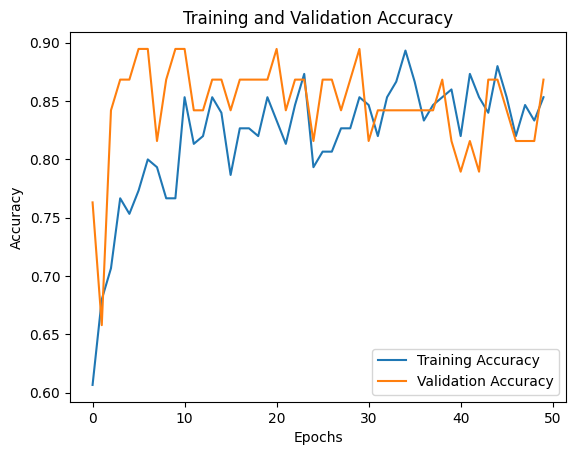

In [ ]:
#BORUTA + FCNN
!pip install boruta
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop(columns=['TYPE'])
y = data['TYPE']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

# Initialize Boruta feature selection
boruta = BorutaPy(estimator=rf, n_estimators='auto', random_state=42, max_iter=100)  # max_iter is the number of iterations
boruta.fit(X_scaled, y.values)

# Retrieve the feature rankings
selected_features = X.columns[boruta.support_].tolist()  # Confirmed important features
tentative_features = X.columns[boruta.support_weak_].tolist()  # Tentative features
rejected_features = X.columns[~(boruta.support_ | boruta.support_weak_)].tolist()  # Rejected features

# Display the feature rankings
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Importance': boruta.ranking_
}).sort_values(by='Importance', ascending=True)

print("Selected Features:", selected_features)
print("Tentative Features:", tentative_features)
print("\nFeature Scores:")
print(feature_scores)

# Filter the dataset to keep only the selected features
X_selected = X[selected_features]

import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_selected.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()



Feature Scores:
      Feature  MI Score
27        HE4  0.292832
29      CA125  0.186252
20        Age  0.150807
31       LYM%  0.132750
41        PCT  0.114418
22        PDW  0.104889
47        ALP  0.092731
8   Menopause  0.090702
42      CO2CP  0.087989
13        ALB  0.085540
36        NEU  0.078655
10        CEA  0.075098
23       CREA  0.069751
7          Mg  0.069654
1       BASO#  0.060741
12     CA19-9  0.057359
5         AST  0.056735
4           K  0.054657
28       LYM#  0.050480
16        MCH  0.048901
24        AFP  0.041602
30        BUN  0.040598
37        EO%  0.038449
9          CL  0.038432
26         Na  0.033714
45      MONO%  0.028765
6       BASO%  0.027377
35        PLT  0.025928
46        MCV  0.023807
34      MONO#  0.020228
14       IBIL  0.017407
3        GLU.  0.016969
18        ALT  0.012851
25        HGB  0.009962
0         MPV  0.003813
19       DBIL  0.000000
33         AG  0.000000
32         Ca  0.000000
38         TP  0.000000
39         UA  0.000000

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5567 - loss: 6.5670 - val_accuracy: 0.5263 - val_loss: 2.7739
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6112 - loss: 6.1754 - val_accuracy: 0.7632 - val_loss: 2.2556
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6922 - loss: 4.6665 - val_accuracy: 0.8158 - val_loss: 2.2522
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7281 - loss: 2.3574 - val_accuracy: 0.7895 - val_loss: 1.6488
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7294 - loss: 4.2279 - val_accuracy: 0.6316 - val_loss: 2.2181
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7332 - loss: 2.6983 - val_accuracy: 0.7895 - val_loss: 1.3730
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6963 - loss: 2.2522 - val_accuracy: 0.7632 - val_loss: 1.4141
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7122 - loss: 2.9533 - val_accuracy: 0.7632 - val_loss: 1.4476
Ep

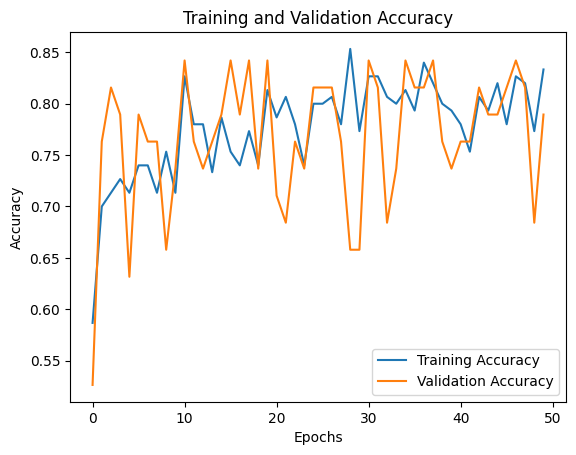

In [ ]:
#MI + FCNN
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = data.drop(columns=['TYPE'])
y = data['TYPE']

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate Mutual Information scores
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)

# Create a DataFrame to display feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

# Display the feature scores
print("\nFeature Scores:")
print(feature_scores)

# Select top features (e.g., top 10 based on MI Score)
top_features = feature_scores['Feature'][:10].tolist()
print("\nTop Selected Features:", top_features)

# Filter the dataset to keep only the top selected features
X_selected = X[top_features]

import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_selected.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Best Alpha: 0.0236
Feature Scores:
      Feature  Coefficient
22        PDW     0.062382
31       LYM%     0.059986
23       CREA     0.035849
18        ALT     0.026703
4           K     0.026016
14       IBIL     0.024699
7          Mg     0.021560
28       LYM#     0.018865
42      CO2CP     0.018312
13        ALB     0.013513
1       BASO#     0.005749
25        HGB     0.000000
26         Na    -0.000000
40        RBC    -0.000000
0         MPV    -0.000000
30        BUN     0.000000
32         Ca     0.000000
33         AG     0.000000
34      MONO#    -0.000000
35        PLT     0.000000
36        NEU    -0.000000
39         UA    -0.000000
19       DBIL    -0.000000
21        RDW    -0.000000
41        PCT    -0.000000
38         TP     0.000000
16        MCH     0.000000
15        GGT     0.000000
12     CA19-9    -0.000000
11        EO#     0.000000
43       TBIL     0.000000
44        HCT     0.000000
45      MONO%    -0.000000
6       BASO%     0.000000
46        MCV     0.

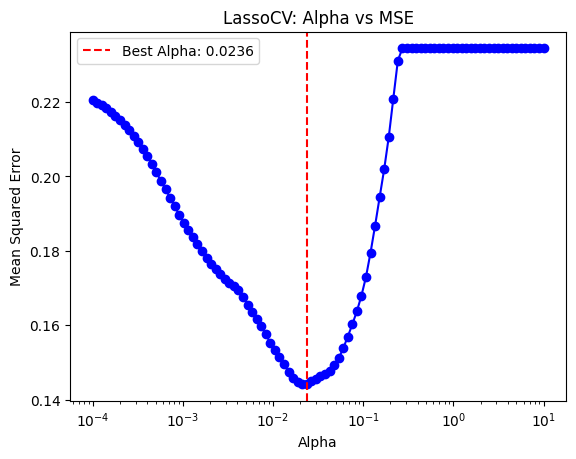

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6271 - loss: 4.8090 - val_accuracy: 0.6579 - val_loss: 0.8875
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6923 - loss: 2.0776 - val_accuracy: 0.8684 - val_loss: 0.6383
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7785 - loss: 1.3380 - val_accuracy: 0.8947 - val_loss: 0.6971
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8366 - loss: 1.5970 - val_accuracy: 0.8684 - val_loss: 0.6538
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7691 - loss: 1.1537 - val_accuracy: 0.8158 - val_loss: 0.6937
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7399 - loss: 1.3825 - val_accuracy: 0.8421 - val_loss: 0.6645
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7916 - loss: 1.2797 - val_accuracy: 0.8421 - val_loss: 0.6435
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7015 - loss: 1.5334 - val_accuracy: 0.7632 - val_loss: 0.

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Test Accuracy: 0.8085106382978723


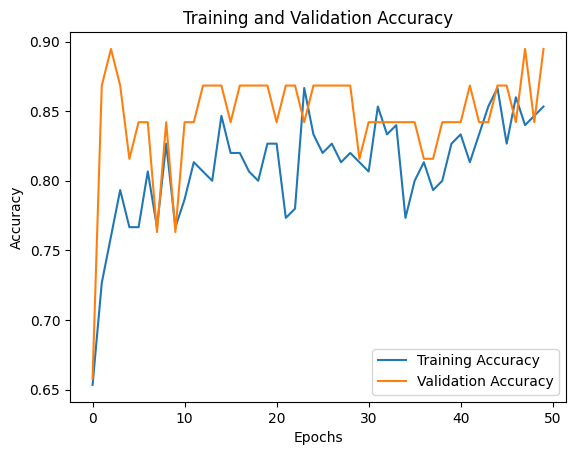

In [ ]:
#LASSO + FCNN
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Separate features and target variable
X = data.drop(columns=['TYPE'])
y = data['TYPE']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (optional, for stability)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply LassoCV for feature selection
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)  # Use cross-validation to find the best alpha
lasso_cv.fit(X_train, y_train)

# Best alpha value
best_alpha = lasso_cv.alpha_
print(f"Best Alpha: {best_alpha:.4f}")

# Fit Lasso with the best alpha
lasso = Lasso(alpha=best_alpha, random_state=42)
lasso.fit(X_train, y_train)

# Get feature importance scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values(by='Coefficient', ascending=False)

# Display the feature scores
print("Feature Scores:")
print(feature_scores)

# Extract selected features (non-zero coefficients)
selected_features = feature_scores[feature_scores['Coefficient'] != 0]['Feature'].tolist()
print(f"Selected Features: {selected_features}")

# Create a new DataFrame with only the selected features
X_select = X[selected_features]

# Optional: Plot alpha vs MSE to visualize the selection process
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), marker='o', color='blue')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('LassoCV: Alpha vs MSE')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Best Alpha: {lasso_cv.alpha_:.4f}')
plt.legend()
plt.show()

import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_select, y, test_size=0.2, random_state=42, stratify=y)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_select.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004171448954105372, tolerance: 0.0034833333333333344
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006213158342168512, tolerance: 0.0034833333333333344
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00982293917803112, tolerance: 0.0034833333333333344
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py

Best Alpha: 0.1918
Best L1 Ratio: 0.10
Feature Scores:
      Feature  Coefficient
22        PDW     0.056949
31       LYM%     0.041320
23       CREA     0.032194
4           K     0.030232
7          Mg     0.026200
28       LYM#     0.023338
14       IBIL     0.023098
18        ALT     0.022706
13        ALB     0.020386
42      CO2CP     0.015968
1       BASO#     0.011292
16        MCH     0.003783
32         Ca     0.000000
30        BUN     0.000000
33         AG     0.000000
34      MONO#    -0.000000
40        RBC    -0.000000
35        PLT     0.000000
26         Na    -0.000000
25        HGB     0.000000
39         UA    -0.000000
0         MPV    -0.000000
21        RDW    -0.000000
41        PCT    -0.000000
19       DBIL    -0.000000
37        EO%    -0.000000
15        GGT     0.000000
11        EO#     0.000000
43       TBIL     0.000000
44        HCT    -0.000000
45      MONO%    -0.000000
6       BASO%     0.000000
46        MCV     0.000000
3        GLU.     0.000000


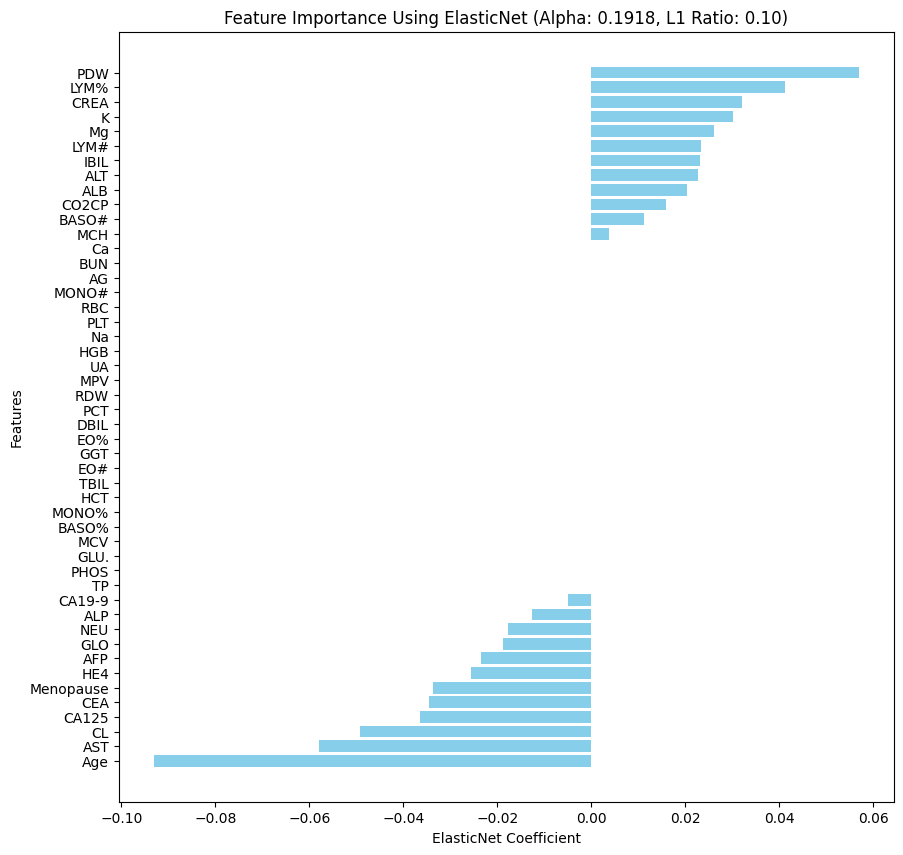

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2961 - loss: 45.6757 - val_accuracy: 0.4737 - val_loss: 11.7200
Epoch 2/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6526 - loss: 8.6552 - val_accuracy: 0.4737 - val_loss: 8.6005
Epoch 3/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7394 - loss: 3.5425 - val_accuracy: 0.7632 - val_loss: 2.7288
Epoch 4/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6813 - loss: 5.3899 - val_accuracy: 0.8158 - val_loss: 2.4044
Epoch 5/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7782 - loss: 2.9518 - val_accuracy: 0.7895 - val_loss: 2.2268
Epoch 6/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6604 - loss: 3.8098 - val_accuracy: 0.5263 - val_loss: 3.3308
Epoch 7/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7399 - loss: 2.5535 - val_accuracy: 0.8158 - val_loss: 1.9522
Epoch 8/80
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8429 - loss: 1.6195 - val_accuracy: 0.8421 - val_loss: 2.3138


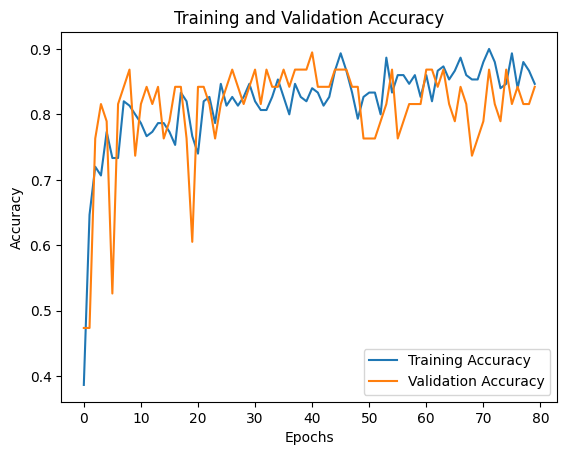

In [ ]:
#ELASTICNET + FCNN
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Separate features and target variable
X = data.drop(columns=['TYPE'])
y = data['TYPE']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data (optional, for stability)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply ElasticNetCV for feature selection
elasticnet_cv = ElasticNetCV(
    alphas=np.logspace(-4, 1, 100),
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0],  # Test different L1-to-L2 ratios
    cv=5,
    random_state=42
)
elasticnet_cv.fit(X_train, y_train)

# Best parameters
best_alpha = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_
print(f"Best Alpha: {best_alpha:.4f}")
print(f"Best L1 Ratio: {best_l1_ratio:.2f}")

# Fit ElasticNet with the best hyperparameters
elasticnet = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
elasticnet.fit(X_train, y_train)

# Get feature importance scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': elasticnet.coef_
}).sort_values(by='Coefficient', ascending=False)

# Display the feature scores
print("Feature Scores:")
print(feature_scores)

# Extract selected features (non-zero coefficients)
selected_features = feature_scores[feature_scores['Coefficient'] != 0]['Feature'].tolist()
print(f"Selected Features: {selected_features}")

X_select2 = X[selected_features]

# Plot the feature scores
plt.figure(figsize=(10,10))
plt.barh(feature_scores['Feature'], feature_scores['Coefficient'], color='skyblue')
plt.xlabel('ElasticNet Coefficient')
plt.ylabel('Features')
plt.title(f'Feature Importance Using ElasticNet (Alpha: {best_alpha:.4f}, L1 Ratio: {best_l1_ratio:.2f})')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

import tensorflow as tf
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_select2, y, test_size=0.2, random_state=42, stratify=y)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_select2.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_split=0.2)

# Evaluate on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
